In [11]:
# !pip install tensorflow matplotlib
# !pip install opencv-python
# pip install tensorflow-gpu==2.6

  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.5.4-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached grpcio-1.63.0-cp39-cp39-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/162.8 kB ? eta -:--:--
     ----------------------------------- -- 153.6/162.8 kB 4.6 MB/s eta 0:00:01
     -------------------------------------- 162.8/162.8 kB 3.2 MB/s eta 0:00:00
  Using c

In [17]:
# import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [18]:
#import dependencies
import cv2
import random
import os #abstracts the os 
import uuid # import uuid library to generate unique image names
import numpy as np
from matplotlib import pyplot as plt

### Create Folder structure

In [16]:
#setup path
# joins different directories and form a full location path
POS_PATH= os.path.join('data','positive') #positive verification images
NEG_PATH= os.path.join('data','negative')#negative verification images
ANC_PATH= os.path.join('data','anchor')#Anchor verification images
ANC_PATH

'data\\anchor'

In [6]:
#create directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

## Dataset: Collect positive and anchors

### Untar Labelled Faces in the wild Dataset

http://vis-www,cs.umass.edu/lfw/

In [20]:
#uncompress targz labelled faces in the wild dataset
!tar -xf lfw.tgz

In [25]:
# Move lfw images to the following repository data/negative
for directory in os.listdir('lfw'): # folder names:Aaron_Eckhart, Aaron_Guiel
    for file in os.listdir(os.path.join('lfw', directory)): #Ex: Aaron_Eckhart_0001.jpg(files inside the directories)
        EX_PATH=os.path.join('lfw',directory,file) # Ex:lfw\Aaron_Eckhart\Aaron_Eckhart_0001.jpg
        NEW_PATH=os.path.join(NEG_PATH,file) # Ex:data\negative\Aaron_Eckhart_0001.jpg
        os.replace(EX_PATH,NEW_PATH)

### Collect positive and anchor classes

In [8]:
# Web cam
#establish a connection to the webcam
cap=cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame=cap.read()
    frame=frame[120:120+250,200:200+250,:] # make it 250 X 250
    
    # collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # create unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write out anchor image
        cv2.imwrite(imgname,frame)
    # collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
         # create unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write out anchor image
        cv2.imwrite(imgname,frame)
    # show image in the screen
    cv2.imshow('Image Collection', frame)
    
    #Breaking
    if cv2.waitKey(1) & 0XFF == ord('q'): # wait 1 ms and check what is pressed from keyboard 
        break
# release the webcam
cap.release()
# close the image show frame
cv2.destroyAllWindows()


### Data Augmentation

In [15]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [29]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)

    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [20]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())


# Load and preprocess Images
### Get Image Directories

In [19]:
anchor=tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000) # search the paths which matches 'data\\anchor\\*.jpg'
positive=tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative=tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [20]:
directory=anchor.as_numpy_iterator()
len(anchor)

3000

In [21]:
directory.next()

b'data\\anchor\\5ed33710-0875-11ef-af87-de41c3084d52.jpg'

### Preprocessing

In [22]:
def preprocess(path):
    # read the image from the path
    byte_img=tf.io.read_file(path)
    # load the image
    img= tf.io.decode_jpeg(byte_img)
    # preprocessing - resizing the image to 100X100
    img=tf.image.resize(img,(100,100))
    # scale image to be between 0 and 1
    img=img/255.0
    return img

### Create labelled dataset

In [ ]:
# (anchor,positive)->1,1,1,1,1-'verified'
# (anchor,negative)->0,0,0,0,0-'unverified'

In [24]:
positives=tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives= tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data=positives.concatenate(negatives)

In [25]:
data # ((file path to image ),(path to either poitive or negative image),(0 or 1))

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

### Build Train and Test Partition

In [30]:
def preprocess_twin(input_img,validation_img,label):
    return(preprocess(input_img),preprocess(validation_img),label)

In [33]:
# build a dataloader pipeline
data=data.map(preprocess_twin)
data= data.cache()
data=data.shuffle(buffer_size=10000) # shuffle to have a mixed set of pos and neg

In [34]:
samples=data.as_numpy_iterator()

In [35]:
exx=samples.next()

In [36]:
len(exx)

3

label= 0.0


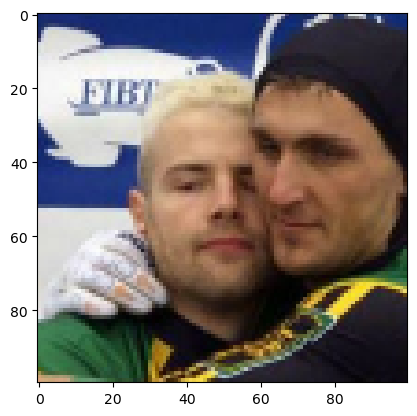

In [38]:
plt.imshow(exx[1])
print('label=',exx[2])

In [39]:
# Training partition
train_data=data.take(round(len(data)*.7)) #70 %
train_data=train_data.batch(16) # create batches
train_data=train_data.prefetch(8) # starts preprocessing the next set of batches

In [40]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [41]:
train_samples=train_data.as_numpy_iterator()
sam=train_samples.next()
len(sam[0])

16

In [42]:
# Testing partition
test_data=data.skip(round(len(data)*.7)) #skip 420 imgs
test_data=test_data.take(round(len(data)*.3)) #last 180 imgs
test_data=test_data.batch(16)
test_data=test_data.prefetch(8)

# Model Engineering

### Build Embedding Layer

In [43]:
inp= Input(shape=(105,105,3),name='input_image')

In [44]:
c1=Conv2D(64,(10,10),activation='relu')(inp)
m1=MaxPooling2D(64,(2,2),padding='same')(c1)

In [45]:
c1

<KerasTensor: shape=(None, 96, 96, 64) dtype=float32 (created by layer 'conv2d')>

In [46]:
m1

<KerasTensor: shape=(None, 48, 48, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [47]:
c2=Conv2D(128,(7,7),activation='relu')(m1)
m2=MaxPooling2D(64,(2,2),padding='same')(c2)

In [48]:
m2

<KerasTensor: shape=(None, 21, 21, 128) dtype=float32 (created by layer 'max_pooling2d_1')>

In [49]:
c3=Conv2D(128,(4,4),activation='relu')(m2)
m3=MaxPooling2D(64,(2,2),padding='same')(c3)

In [50]:
m3

<KerasTensor: shape=(None, 9, 9, 128) dtype=float32 (created by layer 'max_pooling2d_2')>

In [51]:
c4=Conv2D(256,(4,4),activation='relu')(m3)
f1=Flatten()(c4) # 3-D to 1-D
d1=Dense(4096,activation='sigmoid')(f1)

In [52]:
c4

<KerasTensor: shape=(None, 6, 6, 256) dtype=float32 (created by layer 'conv2d_3')>

In [53]:
mod=Model(inputs=[inp],outputs=[d1],name='embedding')

In [54]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

In [55]:
def embedding_model(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [56]:
embedding=embedding_model()

In [106]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

## Build Distance Layer

In [57]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [59]:
l1=L1Dist()
l1

## Siamese Model

In [108]:
def build_siamese_model():
    
    #Anchor image input in the network
    input_image=Input(name='input_img',shape=(100,100,3))
    
    # Validation image in the network
    validation_image=Input(name='validation_img',shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer=L1Dist()
    siamese_layer._name='distance' # name the layer
    input_emb=embedding(input_image)
    validation_image_emb=embedding(validation_image)
    distances=siamese_layer(embedding(input_image),embedding(validation_image))
    
    
    #classification layer
    classifier=Dense(1,activation='sigmoid')(distances)
    return Model(inputs=[input_image,validation_image],outputs=classifier,name='SiameseNetwork')

In [60]:
# what happens in above code step by step
input_image=Input(name='input_img',shape=(100,100,3))
validation_image=Input(name='validation_img',shape=(100,100,3))

In [61]:
input_emb=embedding(input_image)
input_emb # 4096 same as the paper last layer

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [62]:
validation_emb=embedding(validation_image)
validation_emb # 4096 same as the paper last layer

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [63]:
siamese_layer=L1Dist()
distances=siamese_layer(input_emb[0],validation_emb[0])# here is the difference which should be passed to another layer(0 or 1)

In [65]:
distances

<KerasTensor: shape=(4096,) dtype=float32 (created by layer 'l1_dist_3')>

In [109]:
# use the above model
siamese_model=build_siamese_model()

# Training
## Setup Loss and Optimizer

In [110]:
binary_cross_loss=tf.losses.BinaryCrossentropy()

In [111]:
opt= tf.keras.optimizers.Adam(1e-4)# 0.0001

## Establish Checkpoints

In [112]:
checkpoint_dir='./training_checkpoints'
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')
checkpoint=tf.train.Checkpoint(opt=opt,siamese_model=siamese_model)

## Build Train Step Function

In [86]:
test_batch= train_data.as_numpy_iterator()
b1=test_batch.next()
b1[2]

array([0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.],
      dtype=float32)

In [104]:
X=b1[:2]
np.array(X).shape
#(2, 16, 100, 100, 3)- 2 components (anchor,pos/neg),each batch has 16 images
# with shape 100 X 100 by 3

(2, 16, 100, 100, 3)

In [113]:
@tf.function # decorator:it compiles a function into callable Tensorflow graph
def train_step(batch):
    # record all the operations
    with tf.GradientTape() as tape:
        # Get anchor and pos/neg image
        X=batch[:2]
        # get label
        y=batch[2]
        
        # forward pass
        yhat=siamese_model(X,training=True)
        # Calculate loss
        loss=binary_cross_loss(y,yhat)
    # calculate gradients
    grad=tape.gradient(loss,siamese_model.trainable_variables)
    
    # calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    return loss
    

### Build training loop

In [114]:
from tensorflow.keras.metrics import Precision,Recall

In [115]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

# Train

In [116]:
epochs=40

In [117]:
train(train_data,epochs)


 Epoch 1/40
263/263 [==============================] - 1333s 5s/step
0.016261302 0.86653954 0.9875068

 Epoch 2/40
1/1 [==============================] - 1s 860ms/step


263/263 [==============================] - 1259s 5s/step
0.0995608 0.9662868 0.98978597

 Epoch 3/40
1/1 [==============================] - 1s 915ms/step


263/263 [==============================] - 1306s 5s/step
0.008245456 0.98720986 0.9971292

 Epoch 4/40
1/1 [==============================] - 1s 891ms/step


263/263 [==============================] - 1285s 5s/step
0.00023345614 0.98474735 0.99614275

 Epoch 5/40
1/1 [==============================] - 1s 895ms/step


263/263 [==============================] - 1274s 5s/step
0.00054082595 0.9918893 0.99855906

 Epoch 6/40
1/1 [==============================] - 1s 880ms/step


263/263 [==============================] - 1266s 5s/step
0.028449094 0.98701924 0.9990268

 Epoch 7/40
1/1 [==============================] - 1s 901ms/step


263/263 [==============================] - 1297s 5s/step
0.00047238613 0.9961741 0.99856186

 Epoch 8/40
263/263 [==============================] - 1384s 5s/step
0.0020595256 0.99427754 0.9995206

 Epoch 9/40
1/1 [==============================] - 1s 765ms/step


263/263 [==============================] - 1345s 5s/step
0.026035065 0.9980934 0.9995227

 Epoch 10/40
1/1 [==============================] - 1s 1s/step6:


263/263 [==============================] - 1479s 6s/step
0.123809196 0.99386215 0.9995252

 Epoch 11/40
1/1 [==============================] - 1s 795ms/step


263/263 [==============================] - 1226s 5s/step
0.0063024918 0.99807876 0.99903846

 Epoch 12/40
1/1 [==============================] - 1s 939ms/step


263/263 [==============================] - 1304s 5s/step
0.112544 0.99136275 0.9995162

 Epoch 13/40
1/1 [==============================] - 1s 885ms/step


263/263 [==============================] - 1318s 5s/step
7.790804e-05 0.9976437 0.9995279

 Epoch 14/40
1/1 [==============================] - 1s 899ms/step


263/263 [==============================] - 1298s 5s/step
0.0 0.99479413 0.9995245

 Epoch 15/40
263/263 [==============================] - 1281s 5s/step
0.018332263 0.9951527 0.9990268

 Epoch 16/40
1/1 [==============================] - 1s 890ms/step


263/263 [==============================] - 1288s 5s/step
0.01174053 0.9985687 1.0

 Epoch 17/40
1/1 [==============================] - 1s 885ms/step


263/263 [==============================] - 1277s 5s/step
0.057845797 0.9981413 0.99953467

 Epoch 18/40
1/1 [==============================] - 1s 930ms/step


263/263 [==============================] - 1257s 5s/step
0.0053256205 0.9958022 0.9990641

 Epoch 19/40
1/1 [==============================] - 1s 828ms/step


263/263 [==============================] - 1349s 5s/step
0.029063929 0.9908785 0.99903196

 Epoch 20/40
1/1 [==============================] - 1s 881ms/step


263/263 [==============================] - 1279s 5s/step
0.0007898213 0.9914081 0.999038

 Epoch 21/40
1/1 [==============================] - 1s 826ms/step


263/263 [==============================] - 1282s 5s/step
0.0131865535 0.99763036 0.9985769

 Epoch 22/40
263/263 [==============================] - 1296s 5s/step
0.006507906 0.9995236 1.0

 Epoch 23/40
1/1 [==============================] - 1s 850ms/step


263/263 [==============================] - 1370s 5s/step
8.799666e-05 1.0 0.99903756

 Epoch 24/40
1/1 [==============================] - 1s 1s/step1:


263/263 [==============================] - 1410s 5s/step
3.886818e-05 0.99952424 0.99904895

 Epoch 25/40
1/1 [==============================] - 1s 790ms/step


263/263 [==============================] - 1156s 4s/step
0.000113400296 0.9957587 0.999527

 Epoch 26/40
1/1 [==============================] - 1s 791ms/step


263/263 [==============================] - 1181s 4s/step
1.6242348e-06 0.99377394 0.99711674

 Epoch 27/40
1/1 [==============================] - 1s 800ms/step


263/263 [==============================] - 1230s 5s/step
0.0030067733 0.9990508 0.9995252

 Epoch 28/40
1/1 [==============================] - 1s 864ms/step


263/263 [==============================] - 1224s 5s/step
6.122461e-05 1.0 1.0

 Epoch 29/40
263/263 [==============================] - 1184s 5s/step
0.00050601945 1.0 1.0

 Epoch 30/40
1/1 [==============================] - 1s 770ms/step


263/263 [==============================] - 1167s 4s/step
0.0055977623 0.9980943 1.0

 Epoch 31/40
1/1 [==============================] - 1s 830ms/step


263/263 [==============================] - 1199s 5s/step
0.0014829934 0.9990526 1.0

 Epoch 32/40
1/1 [==============================] - 1s 791ms/step


263/263 [==============================] - 1209s 5s/step
3.9553815e-05 1.0 0.9995252

 Epoch 33/40
1/1 [==============================] - 1s 799ms/step


263/263 [==============================] - 1155s 4s/step
0.00027606706 0.9990557 1.0

 Epoch 34/40
1/1 [==============================] - 1s 815ms/step


263/263 [==============================] - 1156s 4s/step
3.0610732e-05 0.9990521 0.99952585

 Epoch 35/40
1/1 [==============================] - 1s 815ms/step


263/263 [==============================] - 1155s 4s/step
3.4719978e-06 1.0 0.9995185

 Epoch 36/40
263/263 [==============================] - 1141s 4s/step
0.022193769 0.99809796 1.0

 Epoch 37/40
1/1 [==============================] - 1s 777ms/step


263/263 [==============================] - 1159s 4s/step
3.561427e-06 1.0 1.0

 Epoch 38/40
1/1 [==============================] - 1s 810ms/step


263/263 [==============================] - 1163s 4s/step
8.724829e-06 1.0 1.0

 Epoch 39/40
1/1 [==============================] - 1s 776ms/step


263/263 [==============================] - 1147s 4s/step
0.0 1.0 1.0

 Epoch 40/40
1/1 [==============================] - 1s 796ms/step


263/263 [==============================] - 1206s 5s/step
0.17069927 0.998557 1.0


# Save model

In [125]:
# save weights
siamese_model.save('siamesemodelv3.h5')

C:\Users\SHREY\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
# Reload model 
model = tf.keras.models.load_model('siamesemodelv3.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

## Evaluate model


In [103]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [104]:
predictions = model.predict([test_input, test_val])

1/1 [==============================] - 1s 936ms/step


In [105]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in predictions ]

[1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]

In [106]:
y_true

array([0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

### Calculate Metrics

In [122]:
#create the object
r=Recall()

# calculating the recall value
r.update_state(y_true,predictions)

# return result 
r.result().numpy()

1.0

In [123]:
#create the object
p=Precision()

# calculating the recall value
p.update_state(y_true,predictions)

# return result 
p.result().numpy()

1.0

In [124]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 485ms/step
1.0 1.0


# Results

In [113]:
# predictions with reloaded model
model.predict([test_input,test_val])

1/1 [==============================] - 1s 990ms/step


array([[7.6806784e-01],
       [9.9974984e-01],
       [2.2210179e-12],
       [9.9860650e-01],
       [9.8360378e-01],
       [3.4684946e-12],
       [9.8841357e-01],
       [1.5134533e-12],
       [2.1322860e-11],
       [9.9887431e-01],
       [1.4444944e-12],
       [4.3706443e-08],
       [5.0205296e-14],
       [3.1749645e-11],
       [3.7075331e-13],
       [2.2701932e-10]], dtype=float32)

In [114]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# Real time Test

## Verification function

In [115]:
os.path.join('application_data', 'input_images', 'input_image.jpg')

'application_data\\input_images\\input_image.jpg'

In [12]:
def verify(model, detection_threshold, verification_threshold):
    results=[]
    for image in os.listdir(os.path.join('application_data','verification_images')):
        input_img=preprocess(os.path.join('application_data','input_images','input_image.jpg'))
        validation_img= preprocess(os.path.join('application_data','verification_images',image))
        
        result=model.predict(list(np.expand_dims([input_img,validation_img],axis=1)))
        results.append(result)
        
     #detection_threshold:  Metric above which a prediction is considered positive (50%)
    detection=np.sum(np.array(results)>detection_threshold)
    
    # Verfification threshold: proportion of positive predictions/total positive samples
    verification=detection/len(os.listdir(os.path.join('application_data','verification_images')))
    verified=verification>verification_threshold
    
    return results, verified

### OpenCV real time Verification

In [13]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_images', 'input_image.jpg'), frame)
        # Run verification
        results, verified= verify(model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 126ms/step
True
1/1 [==============================] - 0s 103ms/step
True
